# EE 519 — Time-domain Analysis of speech (Notebook 1)
## Framing and Windowing (Short-Time Analysis Foundations)

### Goals
By the end of this notebook, you will be able to:
1. Convert **frame length** and **hop size** from milliseconds to samples.
2. Implement **non-overlapping** and **overlapping** framing.
3. Compute the **number of frames** and map **frame index ↔ time**.
4. Generate common windows (Rectangular, Hamming, Hann) and apply them.
5. Visualize **spectral leakage** and the **main-lobe / sidelobe trade-off** using FFT.

### What you need
- A speech signal from **Notebook 0** (preferred) or any `.wav` file.

---
## 0) Setup
We’ll keep utilities simple and readable.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from IPython.display import Audio, display

plt.rcParams["figure.figsize"] = (12, 3)
plt.rcParams["axes.grid"] = True

def to_mono(x):
    x = np.asarray(x)
    if x.ndim == 2:
        x = x.mean(axis=1)
    if np.issubdtype(x.dtype, np.integer):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
    return np.clip(x, -1.0, 1.0)

def play_audio(x, fs):
    display(Audio(x, rate=fs))

def plot_waveform(x, fs, title="Waveform", tlim=None):
    t = np.arange(len(x)) / fs
    plt.figure()
    plt.plot(t, x, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    plt.show()

---
## 1) Load a speech signal

### Option A (recommended): use your recording from Notebook 0
If you saved a WAV from Notebook 0, load it here.


Loaded: speech.wav
Sampling rate (Hz): 16000
Duration (s): 3.0


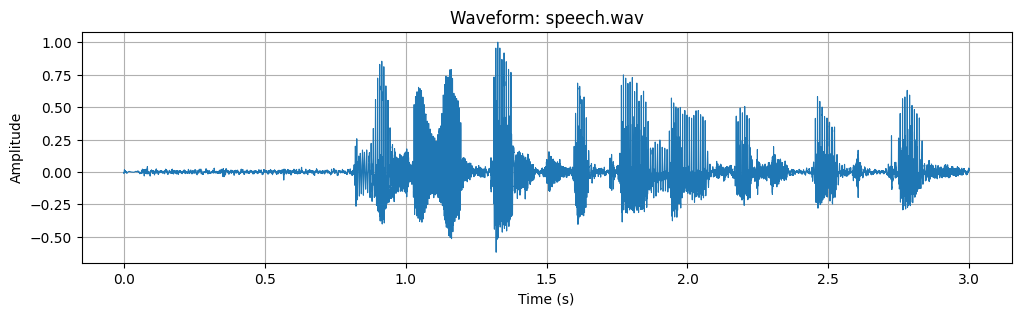

In [2]:
wav_path = "speech.wav"  # <- change as needed

if not os.path.exists(wav_path):
    print(f"File not found: {wav_path}\nUpload a WAV and update wav_path.")
else:
    fs, x = wavfile.read(wav_path)
    x = to_mono(x)
    print("Loaded:", wav_path)
    print("Sampling rate (Hz):", fs)
    print("Duration (s):", len(x)/fs)
    play_audio(x, fs)
    plot_waveform(x, fs, title=f"Waveform: {wav_path}")

---
## 2) From milliseconds to samples

We typically specify frame length and hop size in **milliseconds**, but we implement them in **samples**.

- Frame length (samples):
\[N = \text{round}(\text{frame\_ms} \cdot 10^{-3} \cdot F_s)\]
- Hop size (samples):
\[
H = \text{round}(\text{hop\_ms} \cdot 10^{-3} \cdot F_s)
\]


**Typical speech choices:**
- frame\_ms = 20–30 ms
- hop\_ms = 10 ms


In [2]:
# Try changing these values and re-running!
frame_ms = 25.0
hop_ms   = 10.0

if "x" in globals():
    N = int(round(frame_ms * 1e-3 * fs))
    H = int(round(hop_ms   * 1e-3 * fs))
    print(f"frame_ms={frame_ms} ms -> N={N} samples")
    print(f"hop_ms  ={hop_ms} ms -> H={H} samples")
else:
    print("Load a WAV above first.")

Load a WAV above first.


### Quick questions
1. If you **increase** `frame_ms`, what happens to N? (Does it increase or decrease?)
2. If you **decrease** `hop_ms`, what happens to overlap between frames?

Write your answer in a markdown cell.


---
## 3) How many frames do we get?

If we slide a window of length **N** with hop **H** over a signal of length **L** samples, the number of full frames is:
\[
M = 1 + \left\lfloor \frac{L - N}{H} \right\rfloor
\]

We’ll compute M and also map **frame index → time**.


In [4]:
if "x" in globals():
    L = len(x)
    M = 1 + (L - N) // H if L >= N else 0
    duration = L / fs
    print(f"Signal length L={L} samples ({duration:.2f} s)")
    print(f"Frame length N={N}, hop H={H}")
    print(f"Number of full frames M={M}")

    # Time stamp of each frame center (in seconds)
    frame_centers = (np.arange(M)*H + N/2) / fs
    print("First 5 frame center times (s):", np.round(frame_centers[:5], 4))
else:
    print("Load a WAV above first.")

Signal length L=48000 samples (3.00 s)
Frame length N=400, hop H=160
Number of full frames M=298
First 5 frame center times (s): [0.0125 0.0225 0.0325 0.0425 0.0525]


---
## 4) Implement framing (non-overlapping vs overlapping)

### Two common modes
- **Non-overlapping**: hop = frame length (H = N)
- **Overlapping**: hop < frame length (e.g., 10 ms hop with 25 ms frame)

We’ll implement a framing function and visualize how frames cover the waveform.


In [5]:
def frame_signal(x, N, H):
    """Return frames of shape (M, N) using hop H."""
    L = len(x)
    if L < N:
        return np.zeros((0, N), dtype=np.float32)
    M = 1 + (L - N) // H
    frames = np.zeros((M, N), dtype=np.float32)
    for m in range(M):
        start = m * H
        frames[m] = x[start:start+N]
    return frames

if "x" in globals():
    frames_ov = frame_signal(x, N, H)        # overlapping (default)
    frames_no = frame_signal(x, N, N)        # non-overlapping (H=N)
    print("Overlapping frames shape:", frames_ov.shape)
    print("Non-overlapping frames shape:", frames_no.shape)

Overlapping frames shape: (298, 400)
Non-overlapping frames shape: (120, 400)


### Visualize framing coverage
We’ll plot a short segment of the waveform and overlay a few frame boundaries.


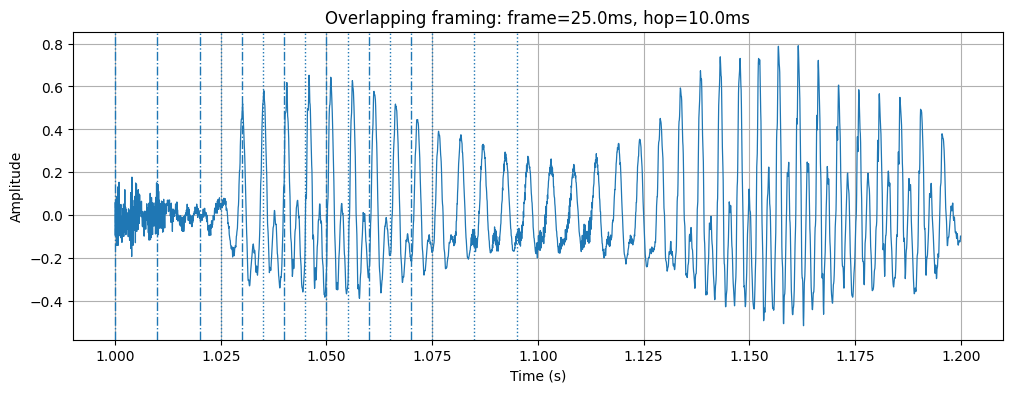

In [28]:
def plot_frames_on_waveform(x, fs, N, H, t0=0.1, t1=0.15, max_frames=8, title="Framing"):
    a = int(t0*fs); b = int(t1*fs)
    t = np.arange(a, b) / fs
    plt.figure(figsize=(12, 4))
    plt.plot(t, x[a:b], linewidth=0.9)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # frame starts within [a,b)
    start0 = (a // H) * H
    count = 0
    for start in range(start0, b, H):
        if start + N < a:
            continue
        if start > b:
            break
        ts = start / fs
        te = (start + N) / fs
        plt.axvline(ts, linestyle="-.", linewidth=1,label="frame")
        plt.axvline(te, linestyle=":", linewidth=1,label="frame")
        count += 1
        if count >= max_frames:
            break
    plt.show()

if "x" in globals():
    plot_frames_on_waveform(x, fs, N, H, t0=1.0, t1=1.2,
                            title=f"Overlapping framing: frame={frame_ms}ms, hop={hop_ms}ms")

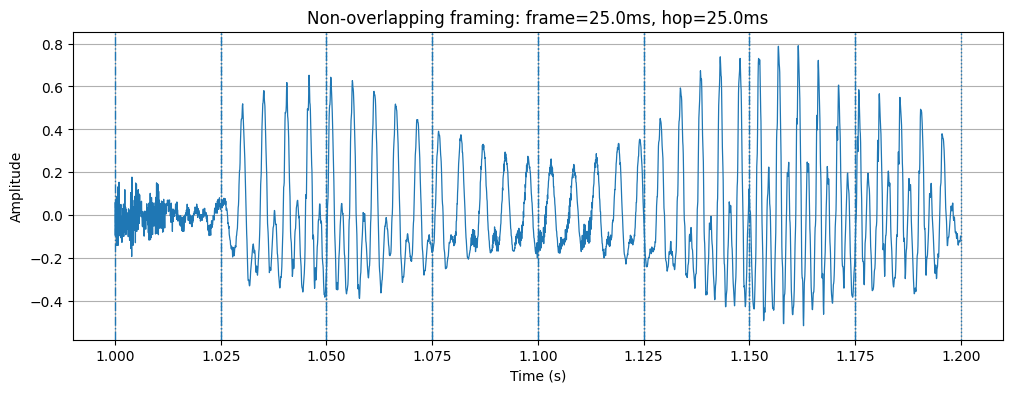

In [29]:
if "x" in globals():
    plot_frames_on_waveform(x, fs, N, N, t0=1.0, t1=1.2, 
                            title=f"Non-overlapping framing: frame={frame_ms}ms, hop={frame_ms}ms")

---
## 5) Window functions

A **window** is a set of weights applied to a frame to reduce boundary discontinuities.

Common windows:
- Rectangular: \(w[n]=1\)
- Hamming: smooth taper (common in speech)
- Hann: smooth taper (similar family)

We’ll generate windows with length **N** and plot them.


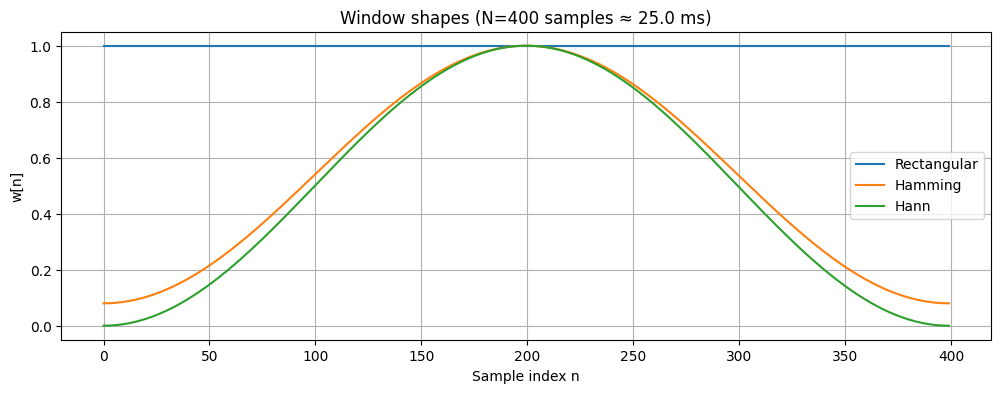

In [30]:
def rect_window(N):
    return np.ones(N, dtype=np.float32)

def hamming_window(N):
    return np.hamming(N).astype(np.float32)

def hann_window(N):
    return np.hanning(N).astype(np.float32)

if "x" in globals():
    w_rect = rect_window(N)
    w_hamm = hamming_window(N)
    w_hann = hann_window(N)

    n = np.arange(N)
    plt.figure(figsize=(12, 4))
    plt.plot(n, w_rect, label="Rectangular")
    plt.plot(n, w_hamm, label="Hamming")
    plt.plot(n, w_hann, label="Hann")
    plt.title(f"Window shapes (N={N} samples ≈ {frame_ms} ms)")
    plt.xlabel("Sample index n")
    plt.ylabel("w[n]")
    plt.legend()
    plt.show()

### Apply windows to a single frame
We’ll take one frame and compare raw vs windowed.


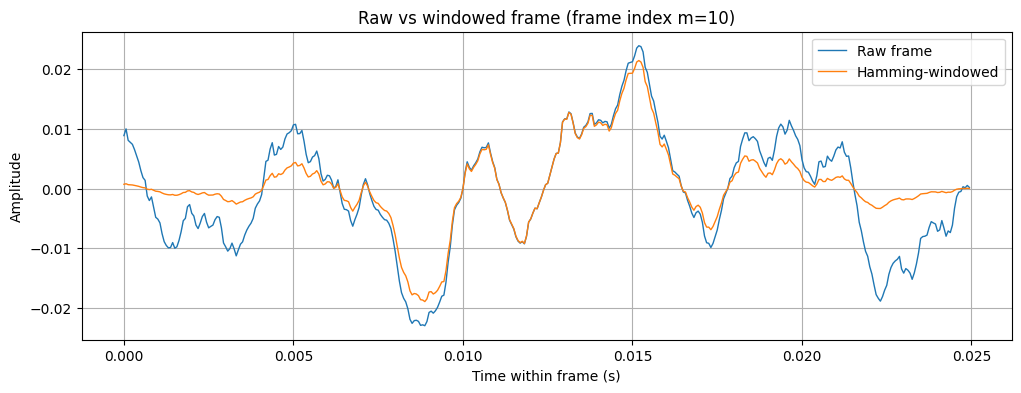

In [31]:
if "x" in globals():
    m = 10  # choose a frame index to inspect (try different values)
    frame = frames_ov[m].copy()

    frame_rect = frame * w_rect
    frame_hamm = frame * w_hamm
    frame_hann = frame * w_hann

    t = np.arange(N) / fs
    plt.figure(figsize=(12, 4))
    plt.plot(t, frame, label="Raw frame", linewidth=1.0)
    plt.plot(t, frame_hamm, label="Hamming-windowed", linewidth=1.0)
    plt.title(f"Raw vs windowed frame (frame index m={m})")
    plt.xlabel("Time within frame (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

---
## 6) Spectral leakage demo (FFT)

Even though this is a *time-domain* lecture, window effects are easiest to see in frequency.

We’ll generate a sinusoid and take a short frame.
- If the sinusoid has an integer number of cycles in the frame, FFT shows a sharp peak.
- If not, energy “leaks” into neighboring frequencies.

**Window choice changes leakage**:
- Rectangular: strong sidelobes (more leakage)
- Hamming/Hann: lower sidelobes (less leakage) but wider main lobe


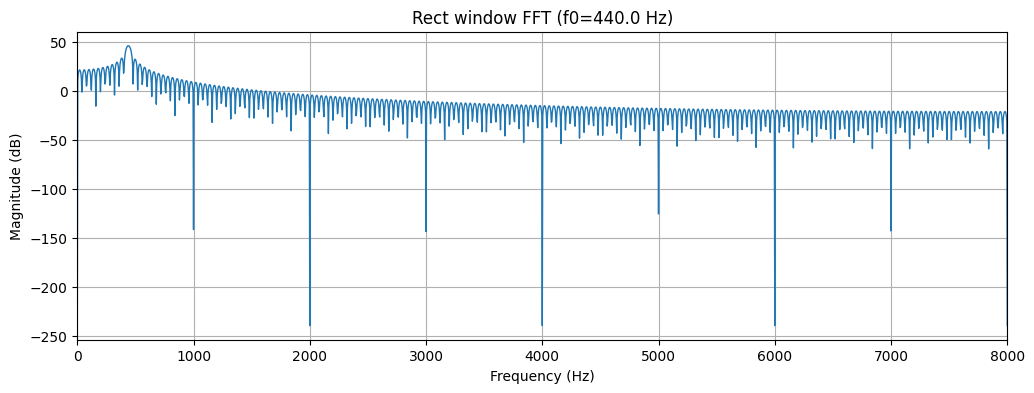

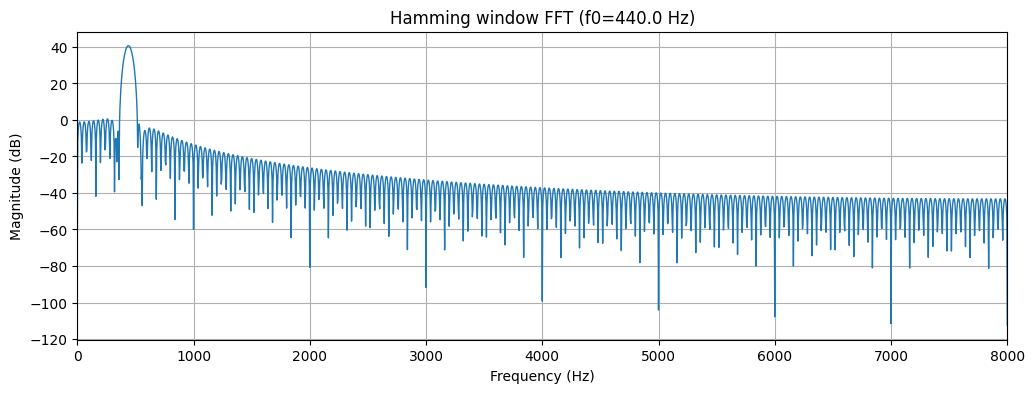

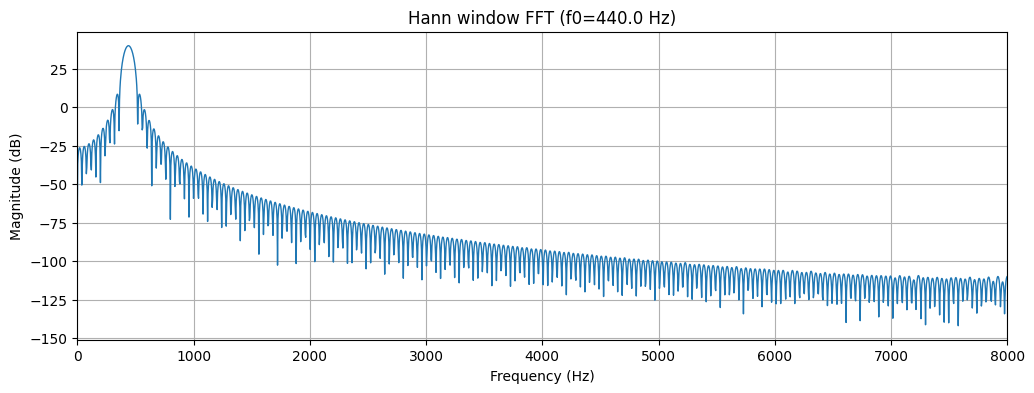

In [15]:
def plot_fft_mag(xw, fs, title="Magnitude spectrum", nfft=4096):
    X = np.fft.rfft(xw, n=nfft)
    f = np.fft.rfftfreq(nfft, d=1/fs)
    mag = 20*np.log10(np.abs(X) + 1e-12)
    plt.figure(figsize=(12, 4))
    plt.plot(f, mag, linewidth=1.0)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title)
    plt.xlim(0, fs/2)
    plt.show()

if "x" in globals():
    fs_demo = fs
    N_demo = N
    t = np.arange(N_demo) / fs_demo

    # Choose a frequency that is NOT an integer number of cycles in the frame (leakage case)
    f0 = 440.0  # try 440, then try something like 437.5
    s = np.sin(2*np.pi*f0*t).astype(np.float32)

    s_rect = s * w_rect
    s_hamm = s * w_hamm
    s_hann = s * w_hann

    plot_fft_mag(s_rect, fs_demo, title=f"Rect window FFT (f0={f0} Hz)")
    plot_fft_mag(s_hamm, fs_demo, title=f"Hamming window FFT (f0={f0} Hz)")
    plot_fft_mag(s_hann, fs_demo, title=f"Hann window FFT (f0={f0} Hz)")

### Exercise: integer vs non-integer cycles
1. Change `f0` so that it aligns better with the FFT bins (leakage reduces).
2. Compare the spectra for different windows.

**Hint:** leakage depends on how the sinusoid fits into the frame length.


---
## 7) Window spectra (window FFT)

We can also look at the **frequency response of the window itself**.
This highlights:
- main-lobe width
- sidelobe level

We’ll compute FFT of each window (zero-padded) and plot it.


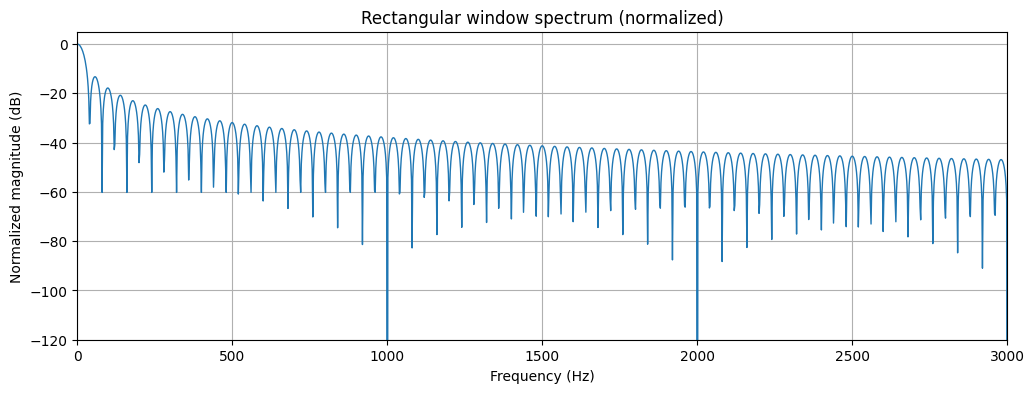

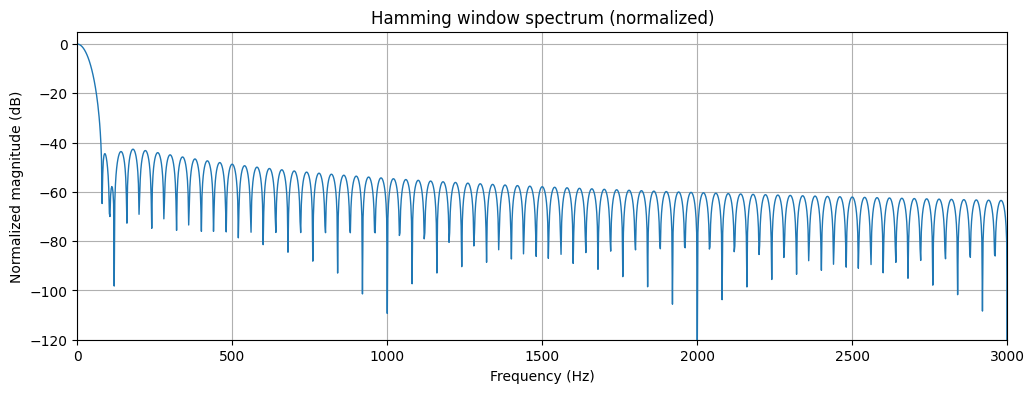

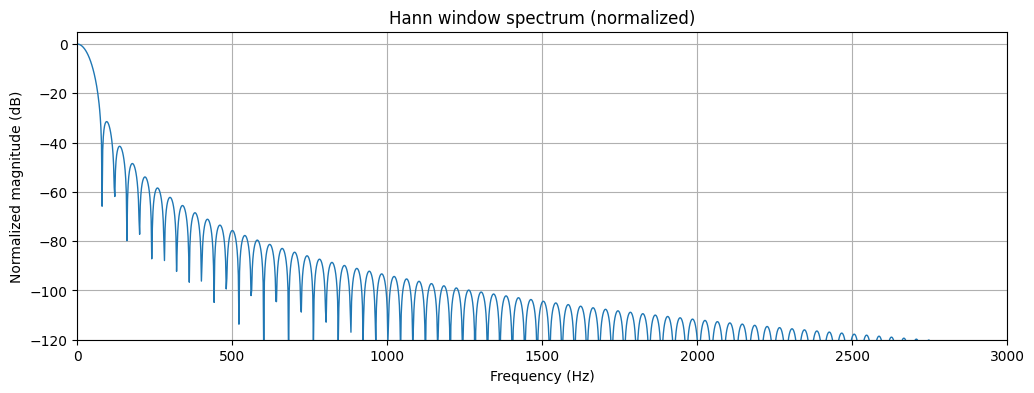

In [16]:
def plot_window_spectrum(w, fs, title, nfft=8192):
    W = np.fft.rfft(w, n=nfft)
    f = np.fft.rfftfreq(nfft, d=1/fs)
    mag = 20*np.log10(np.abs(W) + 1e-12)
    mag = mag - np.max(mag)  # normalize to 0 dB peak
    plt.figure(figsize=(12, 4))
    plt.plot(f, mag, linewidth=1.0)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Normalized magnitude (dB)")
    plt.title(title + " (normalized)")
    plt.xlim(0, 3000)  # zoom into low frequencies to see main-lobe details
    plt.ylim(-120, 5)
    plt.show()

if "x" in globals():
    plot_window_spectrum(w_rect, fs, "Rectangular window spectrum")
    plot_window_spectrum(w_hamm, fs, "Hamming window spectrum")
    plot_window_spectrum(w_hann, fs, "Hann window spectrum")

---
## 8) Summary + what’s next

✅ You can now:
- Convert ms ↔ samples for framing parameters
- Compute number of frames and frame center times
- Implement overlapping and non-overlapping framing
- Generate and apply rectangular/Hamming/Hann windows
- Visualize spectral leakage and window spectra

➡️ Next: **Notebook 2 — Time-domain features**
- short-time energy
- short-time magnitude
- zero crossing rate (ZCR)

### Quick check (answer in a markdown cell)
1. What happens to the **number of frames** when you decrease hop size?
2. Which window seems to reduce sidelobes the most in the window spectrum plots?
3. Why might we prefer Hamming/Hann in speech analysis?
